In [1]:
#From https://www.tensorflow.org/tutorials/generative/cvae

# Global imports
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import cv2

import gzip
import pickle as cPickle
import sys
import os
import random

# Module reload
from importlib import reload


# Local imports
import vae 

#import tensorflow as tf



gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    #tf.config.set_logical_device_configuration(
    #    gpus[0],
    #    [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    #logical_gpus = tf.config.list_logical_devices('GPU')
    tf.config.set_visible_devices([], 'GPU')
    #print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num Virtual GPUS Available: ", len(tf.config.list_logical_devices('GPU')))

2023-03-21 18:09:05.917026: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 18:09:08.981589: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib:/home/henri/ros2_humble/install/rosbag2_storage_mcap/lib:/home/henri/ros2_humble/install/rosbag2_compression_zstd/lib:/home/henri/ros2_humble/install/mcap_vendor/lib:/home/henri/ros2_humble/install/zstd_vendor/lib:/ho

Num GPUs Available:  1
Num CPUs Available:  1
Num Virtual GPUS Available:  0


2023-03-21 18:09:11.011750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 18:09:11.060591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 18:09:11.060881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 18:09:11.061748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [2]:

%load_ext tensorboard

In [3]:
CURRENT_DATASET = 'dataset0'

In [4]:
files = glob.glob(f'data/{CURRENT_DATASET}/*.png')
data = []
for file in files:
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))
    data.append(img)

random.shuffle(data)

def preprocess_images(images):
  images = np.array(images) / 255
  return np.reshape(images, [-1,64, 64, 3]).astype('float32')

def grey_scale(images,colors):
    images = np.dot(images[...,:3], colors)
    images = np.reshape(images, [-1,64, 64, 1]).astype('float32')
    return images
    
  

data = preprocess_images(data)
grey_data = grey_scale(data,[1, -0.5, 0])
    
train,test = grey_data[:int(len(grey_data)*0.8)],grey_data[int(len(grey_data)*0.8):]



0.5019607843137255


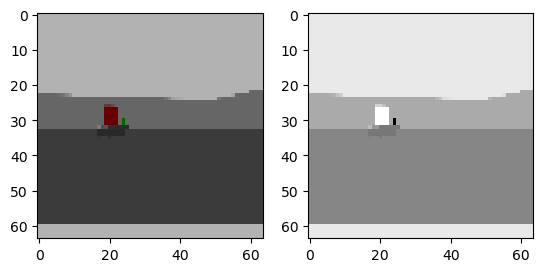

In [5]:
plt.subplot(1,2,1)
plt.imshow(data[3],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(grey_data[3],cmap='gray')
print(np.dot([128/255,0,0],[1, -0.5, 0]))

In [31]:
data[3]
green = np.array([0,128,0])/255
eps = 1e-6
np.logical_and(green - eps <= data[3],data[3] <= green + eps)
#np.sum(np.all(data[3] == ,axis=2))


#prey_area = np.sum(np.all(data[3] == [0,128,0], axis=1))
#prey_r = np.sqrt(prey_area)

#prey_r, prey_area

array([[[0.69803923, 0.69803923, 0.69803923],
        [0.69803923, 0.69803923, 0.69803923],
        [0.69803923, 0.69803923, 0.69803923],
        ...,
        [0.69803923, 0.69803923, 0.69803923],
        [0.69803923, 0.69803923, 0.69803923],
        [0.69803923, 0.69803923, 0.69803923]],

       [[0.69803923, 0.69803923, 0.69803923],
        [0.69803923, 0.69803923, 0.69803923],
        [0.69803923, 0.69803923, 0.69803923],
        ...,
        [0.69803923, 0.69803923, 0.69803923],
        [0.69803923, 0.69803923, 0.69803923],
        [0.69803923, 0.69803923, 0.69803923]],

       [[0.69803923, 0.69803923, 0.69803923],
        [0.69803923, 0.69803923, 0.69803923],
        [0.69803923, 0.69803923, 0.69803923],
        ...,
        [0.69803923, 0.69803923, 0.69803923],
        [0.69803923, 0.69803923, 0.69803923],
        [0.69803923, 0.69803923, 0.69803923]],

       ...,

       [[0.69803923, 0.69803923, 0.69803923],
        [0.69803923, 0.69803923, 0.69803923],
        [0.69803923, 0

In [43]:
train_size = 60000
batch_size = 32
test_size = 10000


In [44]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test)
                .shuffle(test_size).batch(batch_size))


In [45]:
learning_rate = 0.0001
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)

In [46]:
current_epoch = 0
epochs = 20
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 32
num_examples_to_generate = 16


# keep the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :]

In [47]:
import ae
reload(ae)
model = ae.CAE(latent_dim)
model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError())

In [48]:
model.load_weights('checkpoints/ae')

In [49]:
model.encoder.input.shape,model.encoder.output.shape,model.decoder.input.shape,model.decoder.output.shape
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 31, 31, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 flatten_2 (Flatten)         (None, 14400)             0         
                                                                 
 dense_4 (Dense)             (None, 32)                460832    
                                                                 
Total params: 479,648
Trainable params: 479,648
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)          

In [13]:
train.shape , test.shape

((461, 64, 64, 1), (116, 64, 64, 1))

In [50]:
import datetime
import model_utils
reload(model_utils)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
file_writer_cm = tf.summary.create_file_writer(log_dir + "/cm")

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    fig = model_utils.generate_and_save_images(model, epoch, model.encode(test_sample))
    img = model_utils.plot_to_image(fig)

    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", img, step=epoch)

def show_predictions(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    fig = plt.figure(figsize=(4, 4))
    real_img = test_sample[0]
    plt.subplot(1, 2, 1)
    plt.imshow(real_img, cmap='gray')
    prediction_tensor = model(real_img.reshape(1,64,64,1))
    prediction = prediction_tensor.numpy().reshape(64,64,1)
    plt.subplot(1, 2, 2)
    plt.imshow(prediction, cmap='gray')

    img = model_utils.plot_to_image(fig)

    with file_writer_cm.as_default():
        tf.summary.image("Predictions", img, step=epoch)



#cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
pred_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=show_predictions)


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoints/ae',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)




In [51]:

model.fit(x=train, 
          y=train, 
          epochs=20, 
          batch_size=batch_size,
          validation_data=(test, test), 
          callbacks=[tensorboard_callback,cm_callback,model_checkpoint_callback,pred_callback])


Epoch 1/20
46/46 [==============================] - 7s 156ms/step - loss: 1.2274e-04 - val_loss: 1.0821e-04
Epoch 2/20
46/46 [==============================] - 7s 150ms/step - loss: 1.0273e-04 - val_loss: 9.7394e-05
Epoch 3/20
46/46 [==============================] - 7s 155ms/step - loss: 9.2791e-05 - val_loss: 9.3394e-05
Epoch 4/20
46/46 [==============================] - 7s 146ms/step - loss: 8.8493e-05 - val_loss: 9.0589e-05
Epoch 5/20
46/46 [==============================] - 6s 137ms/step - loss: 8.5193e-05 - val_loss: 8.8323e-05
Epoch 6/20
46/46 [==============================] - 7s 152ms/step - loss: 8.2141e-05 - val_loss: 8.3687e-05
Epoch 7/20
46/46 [==============================] - 6s 137ms/step - loss: 7.8882e-05 - val_loss: 8.3005e-05
Epoch 8/20
46/46 [==============================] - 6s 138ms/step - loss: 7.6981e-05 - val_loss: 8.0268e-05
Epoch 9/20
46/46 [==============================] - 6s 137ms/step - loss: 7.5080e-05 - val_loss: 7.8968e-05
Epoch 10/20
46/46 [=========

In [18]:
import model_utils
reload(model_utils)

test_losses = []
train_elbos = []
current_epoch = 0
model_utils.clean_epochs()

In [20]:
model.summary()

In [ ]:
model_utils.generate_and_save_images(model, 'epochs/image_at_epoch_{:04d}.png'.format(current_epoch), test_sample)

plt.subplot(1, 1, 1)
plt.plot(test_losses[1:])
plt.plot(train_elbos[1:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
plt.show()

for epoch in range(current_epoch + 1, current_epoch + epochs + 1):
  start_time = time.time()
  train_loss = tf.keras.metrics.Mean()
  for train_x in train_dataset:
    train_loss(model.train_step(train_x))
  end_time = time.time()
  train_elbos.append(-train_loss.result())

  test_loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    test_loss(model.compute_loss(test_x))
  test_loss_result = -test_loss.result()
  test_losses.append(test_loss_result)
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, test_loss_result, end_time - start_time))
  model_utils.generate_and_save_images(model, 'epochs/image_at_epoch_{:04d}.png'.format(epoch), test_sample)
  
  # Plot Losses
  plt.subplot(1, 1, 1)
  plt.plot(train_elbos[1:] if len(train_elbos) > 1 else test_losses)
  plt.plot(test_losses[1:] if len(test_losses) > 1 else test_losses)
  plt.xlabel('Epoch')
  plt.ylabel('ELBO')
  plt.show()

current_epoch += epochs


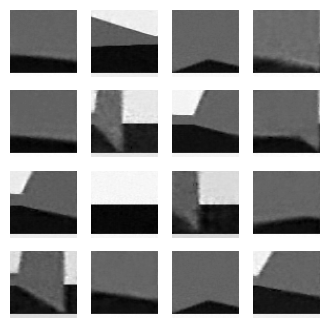

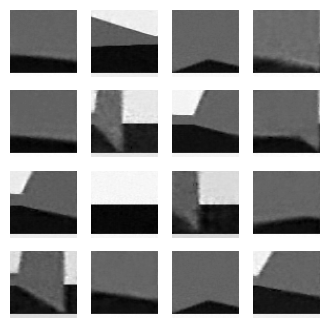

In [52]:
import model_utils
reload(model_utils)

model_utils.generate_and_save_images(model, 'test_samples.png', model.encoder(test_sample))

In [63]:
#plt.plot(train_elbos[1:])
#plt.plot(test_losses[1:])
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.savefig('losses.png')
tensorboard_callback.log_dir




'logs/fit/20230309-152007'

In [53]:
model.save_weights('checkpoints/ae')

In [68]:
reload(model_utils)
model_utils.save_model(model,options={
    'epochs': current_epoch,
    'batch_size': batch_size,
    'latent_dim': latent_dim,
    'optimizer': 'Adam',
    'learning_rate': learning_rate,
    'dataset': CURRENT_DATASET,
    'loss': 'mse',
    'log_dir': tensorboard_callback.log_dir,
}, save_path='attempts/VAE_GreyScaledData')


FileExistsError: [Errno 17] File exists: 'attempts/VAE_GreyScaledData'